# Tonality analysis: HPCP, key and scale detection

In this example we will analyze tonality of a music track. We will analyze the spectrum of an audio signal, find out its spectral peaks using [SpectralPeak](http://essentia.upf.edu/documentation/reference/streaming_SpectralPeaks.html) and then estimate the [harmonic pitch class profile](https://en.wikipedia.org/wiki/Harmonic_pitch_class_profiles) using the [HPCP](http://essentia.upf.edu/documentation/reference/streaming_HPCP.html) algorithm. Finally, we will estimate key and scale of the track based on its HPCP value using the [Key](http://essentia.upf.edu/documentation/reference/streaming_Key.html) algorithm.

In this particular case, it is easier to write the code in streaming mode as it is much simpler.

In [1]:
import essentia.streaming as ess
import essentia

audio_file = '../../../test/audio/recorded/dubstep.flac'

# Initialize algorithms we will use.
loader = ess.MonoLoader(filename=audio_file)
framecutter = ess.FrameCutter(frameSize=4096, hopSize=2048, silentFrames='noise')
windowing = ess.Windowing(type='blackmanharris62')
spectrum = ess.Spectrum()
spectralpeaks = ess.SpectralPeaks(orderBy='magnitude',
                                  magnitudeThreshold=0.00001,
                                  minFrequency=20,
                                  maxFrequency=3500, 
                                  maxPeaks=60)

# Use default HPCP parameters for plots.
# However we will need higher resolution and custom parameters for better Key estimation.

hpcp = ess.HPCP()
hpcp_key = ess.HPCP(size=36, # We will need higher resolution for Key estimation.
                    referenceFrequency=440, # Assume tuning frequency is 44100.
                    bandPreset=False,
                    minFrequency=20,
                    maxFrequency=3500,
                    weightType='cosine',
                    nonLinear=False,
                    windowSize=1.)

key = ess.Key(profileType='edma', # Use profile for electronic music.
              numHarmonics=4,
              pcpSize=36,
              slope=0.6,
              usePolyphony=True,
              useThreeChords=True)

# Use pool to store data.
pool = essentia.Pool() 

# Connect streaming algorithms.
loader.audio >> framecutter.signal
framecutter.frame >> windowing.frame >> spectrum.frame
spectrum.spectrum >> spectralpeaks.spectrum
spectralpeaks.magnitudes >> hpcp.magnitudes
spectralpeaks.frequencies >> hpcp.frequencies
spectralpeaks.magnitudes >> hpcp_key.magnitudes
spectralpeaks.frequencies >> hpcp_key.frequencies
hpcp_key.hpcp >> key.pcp
hpcp.hpcp >> (pool, 'tonal.hpcp')
key.key >> (pool, 'tonal.key_key')
key.scale >> (pool, 'tonal.key_scale')
key.strength >> (pool, 'tonal.key_strength')

# Run streaming network.
essentia.run(loader)

print("Estimated key and scale:", pool['tonal.key_key'] + " " + pool['tonal.key_scale'])

Estimated key and scale: A minor


The audio we have just analyzed:

In [2]:
import IPython
IPython.display.Audio(audio_file)

Let's plot the resulting HPCP:

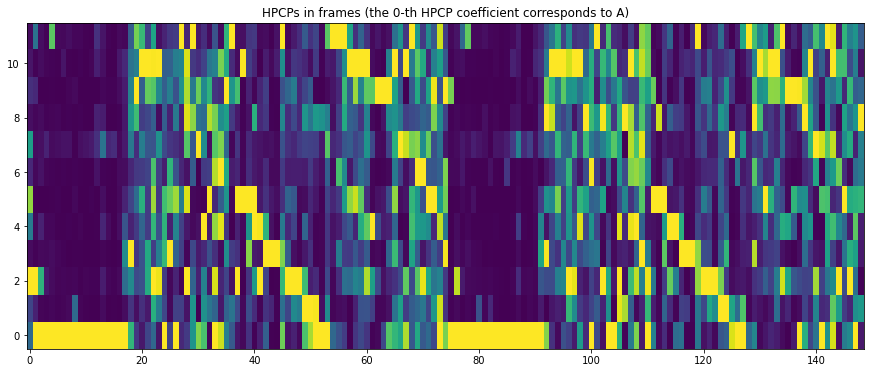

In [3]:
# Plots configuration.
import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow
plt.rcParams['figure.figsize'] = (15, 6)

# Plot HPCP.
imshow(pool['tonal.hpcp'].T, aspect='auto', origin='lower', interpolation='none')
plt.title("HPCPs in frames (the 0-th HPCP coefficient corresponds to A)")
show()

Here we have plotted a 12-bin HPCPgram with default parameters and bins corresponding to semitones from A to G#.

In contrast, in this example, Key/scale estimation is done using 36-bin HPCPs with more resolution and specific parameters for better accuracy. 

Key estimation works by comparing the HPCPs to different distribution profiles suited for different types of music. The one used here, `edma`, is specifically designed for electronic dance music. See the [Key](https://essentia.upf.edu/reference/streaming_Key.html) algorithm for more information about the available profiles.

In [4]:
print("Estimated key and scale:", pool['tonal.key_key'] + " " + pool['tonal.key_scale'])

Estimated key and scale: A minor
